# Generalities for DAEs and VAEs

* Import libraries
* Run on GPU if possible
* Create data loaders

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from IPython.display import Image, display
import matplotlib.pyplot as plt

# create directory to save results
!mkdir dae_results
!mkdir vae_results

# script parameters
batch_size = 128
log_interval = 100

# run on GPU if possible
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

# create data loaders
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



# Neural Network classes

* Deterministic auto-encoder (DAE)
* Variational auto-encoder (VAE)


In [2]:
# Deterministic Auto-Encoder (DAE)
class DAE(nn.Module):

    # declare layers
    def __init__(self):
        super(DAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    # encoder: one ReLU hidden layer of 400 nodes, one Linear output layer of 20 nodes
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h)

    # decoder: one ReLU hidden layer of 400 nodes, one sigmoid output layer of 784 nodes
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    # forward: encoder followed by decoder
    def forward(self, x):
        z = self.encode(x.view(-1, 784))
        return self.decode(z)

# Variational Auto-Encoder (VAE)     
class VAE(nn.Module):

    # declare layers
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc2a = nn.Linear(400, 20) # means
        self.fc2b = nn.Linear(400, 20) # variances
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    # Encoder: one ReLU hidden layer of 400 nodes, two Linear output layers of 20 nodes (means and log_variances)
    # Input: image (array of size 784)
    # Output: means (array of size 20), log_variances (array of size 20)
    def encode(self, x):

        h = F.relu(self.fc1(x)) # ReLU hidden layer of 400 nodes
        means = self.fc2a(h) # Linear output layers of 20 nodes
        log_variances = self.fc2b(h) # Linear output layers of 20 nodes
        return means, log_variances

    # Reparameterization:
    #
    # Let eps be samples from a Normal(0,1)
    # Input: means (array of size 20), log_variances (array of size 20)
    # Output: embedding (array of size 20 corresponding to means + eps * exponential(log_variances/2))
    def reparameterize(self, means, log_variances):

        eps = torch.randn(means.shape[0], 20).to(device)
        embedding = means + eps * torch.exp(log_variances/2)
        return embedding

    # Decoder: one ReLU hidden layer of 400 nodes, one sigmoid output layer of 784 nodes
    # Input: embedding (array of size 20)
    # Output: probability of reconstructed image (array of size 784)
    def decode(self, z):

        h3 = F.relu(self.fc3(z)) # ReLU hidden layer of 400 nodes
        probabilities = torch.sigmoid(self.fc4(h3)) # sigmoid output layer of 784 nodes
        return probabilities

    # Function forward: encoder, reparameterize, decoder
    # Input: image
    # Output: probability of reconstructed image, means, log_variances
    def forward(self, x):

        means, log_variances = self.encode(x.view(-1, 784)) # encode
        embedding = self.reparameterize(means, log_variances) # reparameterize
        probabilities = self.decode(embedding) # decode
        return probabilities, means, log_variances

# Loss Functions

In [3]:
# DAE Loss Function
# Reconstruction loss: binary cross entropy
#
# Inputs:
#    reconstructed_x: reconstructed image
#    x: image
#
# Output:
#    BCE: binary cross entropy  
#
def dae_loss_function(reconstructed_x, x):
    BCE = F.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')
    return BCE

# VAE Loss Function
# Reconstruction loss: binary cross entropy
# KL divergence loss: -0.5 * sum(1 + log_variances - means^2 - exp(log_variances))
#       see Appendix B from VAE paper:
#       Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
#       https://arxiv.org/abs/1312.6114
#
# Inputs: 
#    reconstructed_x: reconstructed image
#    x: image
#    means: array of size 20
#    log_variances: array of size 20
#
# Outputs:
#    total_loss: binary cross entropy + KL divergence (scalar)
#    BCE: binary cross entropy (scalar)
#
def vae_loss_function(reconstructed_x, x, means, log_variances):

    BCE = F.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')
    KL_divergence = -0.5 * torch.sum(1 + log_variances - means**2 - torch.exp(log_variances))
    total_loss = BCE + KL_divergence
    return total_loss, BCE


# Training

In [4]:
# DAE Training
#
# Inputs:
#    epoch: epoch #
#    model: DAE neural network
#    optimizer: DAE optimizer
#
# Outputs:
#    average_train_BCE: binary cross entropy (scalar)
#
def dae_train(epoch, model, optimizer):
    train_BCE = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = dae_loss_function(recon_batch, data)
        loss.backward()
        train_BCE += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    average_train_BCE = train_BCE / len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, average_train_BCE))
    return average_train_BCE

# VAE Training
#
# Inputs:
#    epoch: epoch #
#    model: VAE neural network
#    optimizer: VAE optimizer
#
# Outputs:
#    average_train_loss: binary cross entropy + KL divergence (scalar)
#    average_train_BCE: binary cross entropy (scalar)
#
def vae_train(epoch, model, optimizer):

    train_loss = 0
    train_BCE = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, means, log_variances = model(data)
        loss, BCE = vae_loss_function(recon_batch, data, means, log_variances)
        loss.backward()
        train_loss += loss.item()
        train_BCE += BCE.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tBCE Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data), BCE.item() / len(data)))

    average_train_loss = train_loss / len(train_loader.dataset)
    average_train_BCE = train_BCE / len(train_loader.dataset)
    print('====> Epoch: {} Average train loss: {:.4f} Average BCE loss: {:.4f}'.format(
          epoch, average_train_loss, average_train_BCE))
    return average_train_loss, average_train_BCE



# Testing

In [5]:
# DAE Test
#
# Inputs:
#    epoch: epoch #
#    model: DAE neural network
#
# Outputs:
#    average_test_BCE: binary cross entropy (scalar)
#
def dae_test(epoch, model):
    model.eval()
    test_BCE = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch = model(data)
            test_BCE += dae_loss_function(recon_batch, data).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'dae_results/reconstruction_' + str(epoch) + '.png', nrow=n)
                print('Sample of reconstructed images (top row are targets and bottom row are reconstructions)')
                display(Image('dae_results/reconstruction_' + str(epoch) + '.png'))

    average_test_BCE = test_BCE / len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(average_test_BCE))
    return average_test_BCE

# VAE Test
#
# Inputs:
#    epoch: epoch #
#    model: VAE neural network
#
# Outputs:
#    average_test_loss: binary cross entropy + KL divergence (scalar)
#    average_test_BCE: binary cross entropy (scalar)
#
def vae_test(epoch, model):

    model.eval()
    test_loss = 0
    test_BCE = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, means, log_variances = model(data)
            loss, BCE = vae_loss_function(recon_batch, data, means, log_variances)
            test_loss += loss.item()
            test_BCE += BCE.item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'vae_results/reconstruction_' + str(epoch) + '.png', nrow=n)
                print('Sample of reconstructed images (top row are targets and bottom row are reconstructions)')
                display(Image('vae_results/reconstruction_' + str(epoch) + '.png'))

    average_test_loss = test_loss / len(test_loader.dataset)
    average_test_BCE = test_BCE / len(test_loader.dataset)
    print('====> Test set loss: {:.4f}\tTest set BCE loss: {:.4f}'.format(average_test_loss, average_test_BCE))
    return average_test_loss, average_test_BCE


# Main

Train Epoch: 1 [0/60000 (0%)]	Loss: 544.773682
Train Epoch: 1 [12800/60000 (21%)]	Loss: 158.343353
Train Epoch: 1 [25600/60000 (43%)]	Loss: 121.157166
Train Epoch: 1 [38400/60000 (64%)]	Loss: 97.416077
Train Epoch: 1 [51200/60000 (85%)]	Loss: 91.785629
====> Epoch: 1 Average loss: 132.2062
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


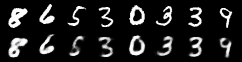

====> Test set loss: 88.0445
Sample of generated images


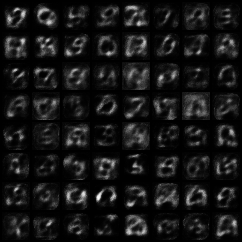



Train Epoch: 2 [0/60000 (0%)]	Loss: 92.121735
Train Epoch: 2 [12800/60000 (21%)]	Loss: 85.216461
Train Epoch: 2 [25600/60000 (43%)]	Loss: 82.393372
Train Epoch: 2 [38400/60000 (64%)]	Loss: 81.663727
Train Epoch: 2 [51200/60000 (85%)]	Loss: 81.875793
====> Epoch: 2 Average loss: 82.8515
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


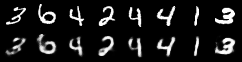

====> Test set loss: 78.0178
Sample of generated images


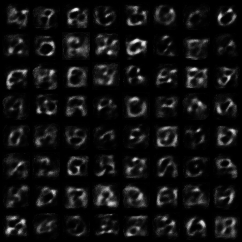



Train Epoch: 3 [0/60000 (0%)]	Loss: 80.674973
Train Epoch: 3 [12800/60000 (21%)]	Loss: 78.844841
Train Epoch: 3 [25600/60000 (43%)]	Loss: 77.060135
Train Epoch: 3 [38400/60000 (64%)]	Loss: 78.527054
Train Epoch: 3 [51200/60000 (85%)]	Loss: 72.299774
====> Epoch: 3 Average loss: 77.1621
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


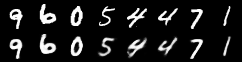

====> Test set loss: 74.7633
Sample of generated images


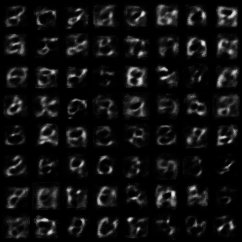



Train Epoch: 4 [0/60000 (0%)]	Loss: 78.030495
Train Epoch: 4 [12800/60000 (21%)]	Loss: 70.297226
Train Epoch: 4 [25600/60000 (43%)]	Loss: 76.109360
Train Epoch: 4 [38400/60000 (64%)]	Loss: 73.875320
Train Epoch: 4 [51200/60000 (85%)]	Loss: 75.455376
====> Epoch: 4 Average loss: 74.4153
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


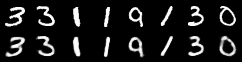

====> Test set loss: 72.7471
Sample of generated images


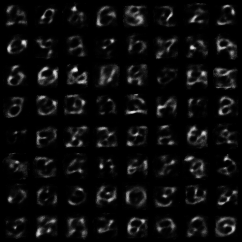



Train Epoch: 5 [0/60000 (0%)]	Loss: 69.406364
Train Epoch: 5 [12800/60000 (21%)]	Loss: 71.735947
Train Epoch: 5 [25600/60000 (43%)]	Loss: 74.636116
Train Epoch: 5 [38400/60000 (64%)]	Loss: 72.921829
Train Epoch: 5 [51200/60000 (85%)]	Loss: 71.729248
====> Epoch: 5 Average loss: 72.6254
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


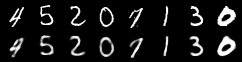

====> Test set loss: 71.4344
Sample of generated images


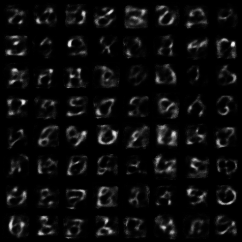



Train Epoch: 6 [0/60000 (0%)]	Loss: 70.589790
Train Epoch: 6 [12800/60000 (21%)]	Loss: 72.150787
Train Epoch: 6 [25600/60000 (43%)]	Loss: 70.898933
Train Epoch: 6 [38400/60000 (64%)]	Loss: 71.566788
Train Epoch: 6 [51200/60000 (85%)]	Loss: 70.532547
====> Epoch: 6 Average loss: 71.3163
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


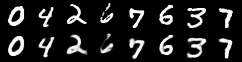

====> Test set loss: 70.4017
Sample of generated images


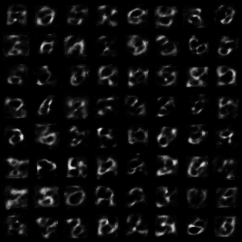



Train Epoch: 7 [0/60000 (0%)]	Loss: 71.580879
Train Epoch: 7 [12800/60000 (21%)]	Loss: 70.785118
Train Epoch: 7 [25600/60000 (43%)]	Loss: 73.742630
Train Epoch: 7 [38400/60000 (64%)]	Loss: 72.128632
Train Epoch: 7 [51200/60000 (85%)]	Loss: 70.055359
====> Epoch: 7 Average loss: 70.3546
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


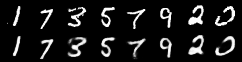

====> Test set loss: 69.7260
Sample of generated images


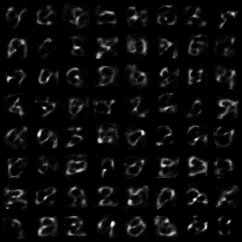



Train Epoch: 8 [0/60000 (0%)]	Loss: 67.234940
Train Epoch: 8 [12800/60000 (21%)]	Loss: 67.468628
Train Epoch: 8 [25600/60000 (43%)]	Loss: 67.195717
Train Epoch: 8 [38400/60000 (64%)]	Loss: 69.030334
Train Epoch: 8 [51200/60000 (85%)]	Loss: 70.617882
====> Epoch: 8 Average loss: 69.5800
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


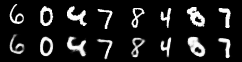

====> Test set loss: 69.0434
Sample of generated images


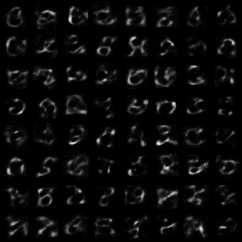



Train Epoch: 9 [0/60000 (0%)]	Loss: 69.880676
Train Epoch: 9 [12800/60000 (21%)]	Loss: 69.606323
Train Epoch: 9 [25600/60000 (43%)]	Loss: 70.262962
Train Epoch: 9 [38400/60000 (64%)]	Loss: 68.896820
Train Epoch: 9 [51200/60000 (85%)]	Loss: 68.210106
====> Epoch: 9 Average loss: 68.9402
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


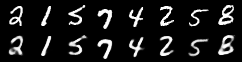

====> Test set loss: 68.5653
Sample of generated images


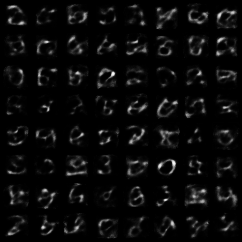



Train Epoch: 10 [0/60000 (0%)]	Loss: 69.077820
Train Epoch: 10 [12800/60000 (21%)]	Loss: 67.209846
Train Epoch: 10 [25600/60000 (43%)]	Loss: 69.095589
Train Epoch: 10 [38400/60000 (64%)]	Loss: 68.318024
Train Epoch: 10 [51200/60000 (85%)]	Loss: 68.668175
====> Epoch: 10 Average loss: 68.3911
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


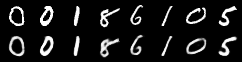

====> Test set loss: 68.1364
Sample of generated images


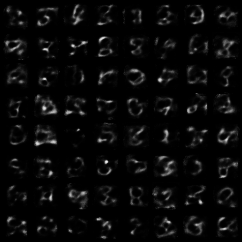



Train Epoch: 1 [0/60000 (0%)]	Loss: 548.381531	BCE Loss: 548.258118
Train Epoch: 1 [12800/60000 (21%)]	Loss: 186.899384	BCE Loss: 176.770905
Train Epoch: 1 [25600/60000 (43%)]	Loss: 154.019119	BCE Loss: 137.344971
Train Epoch: 1 [38400/60000 (64%)]	Loss: 134.161972	BCE Loss: 116.859512
Train Epoch: 1 [51200/60000 (85%)]	Loss: 132.326599	BCE Loss: 112.987946
====> Epoch: 1 Average train loss: 164.8103 Average BCE loss: 149.3050
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


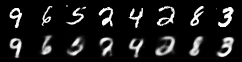

====> Test set loss: 127.2196	Test set BCE loss: 106.1787
Sample of generated images


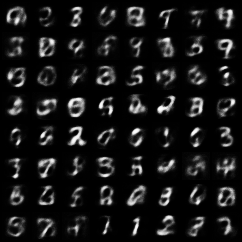



Train Epoch: 2 [0/60000 (0%)]	Loss: 132.010284	BCE Loss: 111.274673
Train Epoch: 2 [12800/60000 (21%)]	Loss: 129.349915	BCE Loss: 106.290001
Train Epoch: 2 [25600/60000 (43%)]	Loss: 121.642181	BCE Loss: 99.598587
Train Epoch: 2 [38400/60000 (64%)]	Loss: 116.902557	BCE Loss: 93.596199
Train Epoch: 2 [51200/60000 (85%)]	Loss: 120.068176	BCE Loss: 97.353363
====> Epoch: 2 Average train loss: 121.3905 Average BCE loss: 98.9670
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


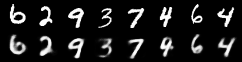

====> Test set loss: 115.7068	Test set BCE loss: 91.1249
Sample of generated images


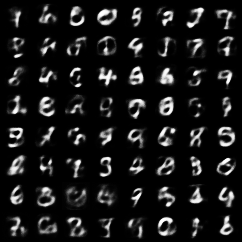



Train Epoch: 3 [0/60000 (0%)]	Loss: 117.621384	BCE Loss: 93.264206
Train Epoch: 3 [12800/60000 (21%)]	Loss: 118.617599	BCE Loss: 94.396561
Train Epoch: 3 [25600/60000 (43%)]	Loss: 113.889206	BCE Loss: 89.602318
Train Epoch: 3 [38400/60000 (64%)]	Loss: 115.314072	BCE Loss: 91.385689
Train Epoch: 3 [51200/60000 (85%)]	Loss: 112.127876	BCE Loss: 88.273735
====> Epoch: 3 Average train loss: 114.5036 Average BCE loss: 90.4698
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


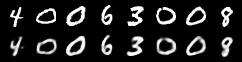

====> Test set loss: 111.7941	Test set BCE loss: 86.9272
Sample of generated images


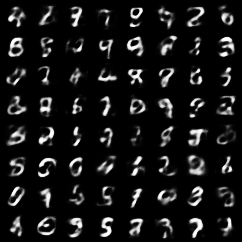



Train Epoch: 4 [0/60000 (0%)]	Loss: 113.914886	BCE Loss: 88.953026
Train Epoch: 4 [12800/60000 (21%)]	Loss: 110.957924	BCE Loss: 87.061691
Train Epoch: 4 [25600/60000 (43%)]	Loss: 114.011017	BCE Loss: 88.870628
Train Epoch: 4 [38400/60000 (64%)]	Loss: 112.065788	BCE Loss: 87.900047
Train Epoch: 4 [51200/60000 (85%)]	Loss: 113.076355	BCE Loss: 88.610107
====> Epoch: 4 Average train loss: 111.5396 Average BCE loss: 86.9315
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


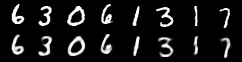

====> Test set loss: 109.6487	Test set BCE loss: 85.0694
Sample of generated images


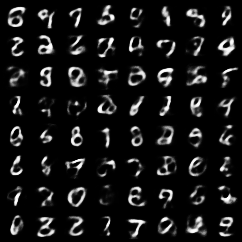



Train Epoch: 5 [0/60000 (0%)]	Loss: 112.736755	BCE Loss: 88.054581
Train Epoch: 5 [12800/60000 (21%)]	Loss: 110.040054	BCE Loss: 84.584396
Train Epoch: 5 [25600/60000 (43%)]	Loss: 105.032532	BCE Loss: 80.369049
Train Epoch: 5 [38400/60000 (64%)]	Loss: 108.171097	BCE Loss: 83.129509
Train Epoch: 5 [51200/60000 (85%)]	Loss: 110.787483	BCE Loss: 85.700600
====> Epoch: 5 Average train loss: 109.8261 Average BCE loss: 84.9154
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


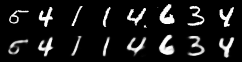

====> Test set loss: 108.4202	Test set BCE loss: 84.0573
Sample of generated images


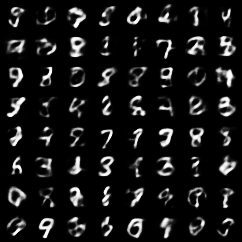



Train Epoch: 6 [0/60000 (0%)]	Loss: 108.612099	BCE Loss: 84.480553
Train Epoch: 6 [12800/60000 (21%)]	Loss: 107.338387	BCE Loss: 83.196121
Train Epoch: 6 [25600/60000 (43%)]	Loss: 112.135712	BCE Loss: 86.183411
Train Epoch: 6 [38400/60000 (64%)]	Loss: 107.926582	BCE Loss: 82.705978
Train Epoch: 6 [51200/60000 (85%)]	Loss: 105.938522	BCE Loss: 80.901352
====> Epoch: 6 Average train loss: 108.6551 Average BCE loss: 83.6428
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


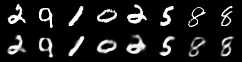

====> Test set loss: 107.6267	Test set BCE loss: 82.8733
Sample of generated images


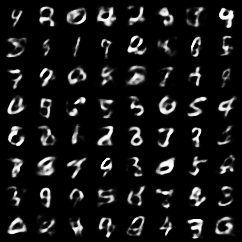



Train Epoch: 7 [0/60000 (0%)]	Loss: 104.893387	BCE Loss: 80.037636
Train Epoch: 7 [12800/60000 (21%)]	Loss: 107.199638	BCE Loss: 82.670181
Train Epoch: 7 [25600/60000 (43%)]	Loss: 109.654213	BCE Loss: 84.668533
Train Epoch: 7 [38400/60000 (64%)]	Loss: 101.720726	BCE Loss: 77.251472
Train Epoch: 7 [51200/60000 (85%)]	Loss: 108.396652	BCE Loss: 82.965912
====> Epoch: 7 Average train loss: 107.8179 Average BCE loss: 82.6712
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


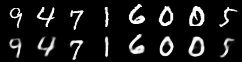

====> Test set loss: 106.8947	Test set BCE loss: 81.9861
Sample of generated images


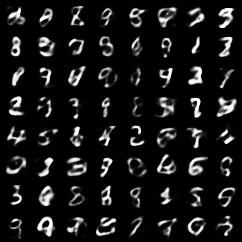



Train Epoch: 8 [0/60000 (0%)]	Loss: 111.693802	BCE Loss: 85.823814
Train Epoch: 8 [12800/60000 (21%)]	Loss: 107.119781	BCE Loss: 81.710175
Train Epoch: 8 [25600/60000 (43%)]	Loss: 109.494286	BCE Loss: 83.585342
Train Epoch: 8 [38400/60000 (64%)]	Loss: 110.540329	BCE Loss: 84.632492
Train Epoch: 8 [51200/60000 (85%)]	Loss: 108.860298	BCE Loss: 83.827438
====> Epoch: 8 Average train loss: 107.2185 Average BCE loss: 81.9944
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


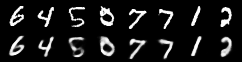

====> Test set loss: 106.5076	Test set BCE loss: 81.4641
Sample of generated images


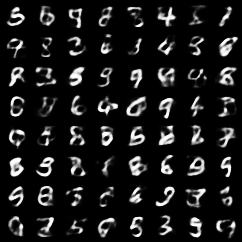



Train Epoch: 9 [0/60000 (0%)]	Loss: 103.856712	BCE Loss: 79.183914
Train Epoch: 9 [12800/60000 (21%)]	Loss: 108.418365	BCE Loss: 82.268745
Train Epoch: 9 [25600/60000 (43%)]	Loss: 106.614685	BCE Loss: 81.449486
Train Epoch: 9 [38400/60000 (64%)]	Loss: 107.173569	BCE Loss: 81.640518
Train Epoch: 9 [51200/60000 (85%)]	Loss: 109.182190	BCE Loss: 83.327103
====> Epoch: 9 Average train loss: 106.7591 Average BCE loss: 81.4763
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


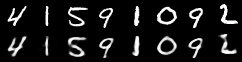

====> Test set loss: 106.3564	Test set BCE loss: 81.1797
Sample of generated images


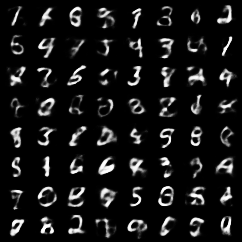



Train Epoch: 10 [0/60000 (0%)]	Loss: 107.488510	BCE Loss: 82.592575
Train Epoch: 10 [12800/60000 (21%)]	Loss: 108.135796	BCE Loss: 82.360451
Train Epoch: 10 [25600/60000 (43%)]	Loss: 106.277718	BCE Loss: 81.275085
Train Epoch: 10 [38400/60000 (64%)]	Loss: 104.003815	BCE Loss: 78.270004
Train Epoch: 10 [51200/60000 (85%)]	Loss: 112.875648	BCE Loss: 86.974480
====> Epoch: 10 Average train loss: 106.2865 Average BCE loss: 80.9891
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


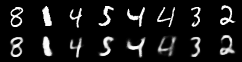

====> Test set loss: 105.5379	Test set BCE loss: 80.4427
Sample of generated images


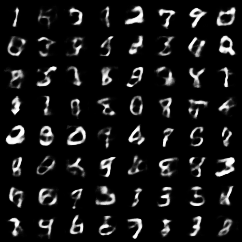

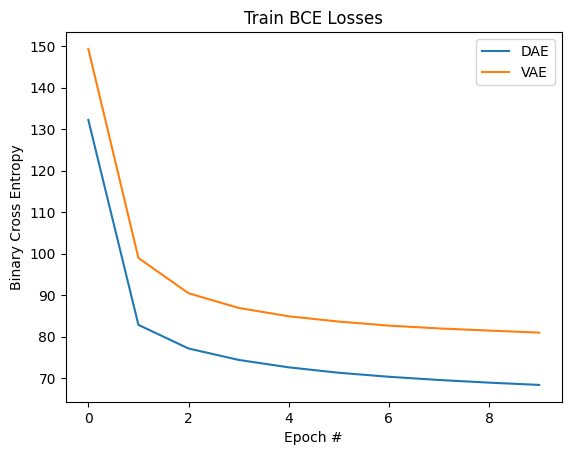

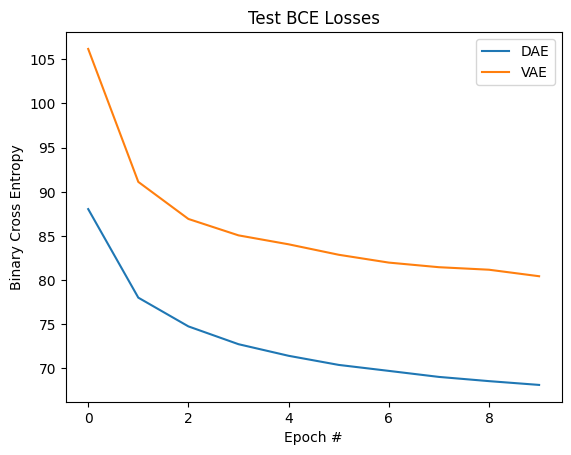

In [6]:
# train and test DAE
epochs = 10
dae_average_train_BCE = []
dae_average_test_BCE = []
dae_model = DAE().to(device)
dae_optimizer = optim.Adam(dae_model.parameters(), lr=1e-3)
for epoch in range(1, epochs + 1):
    average_train_BCE = dae_train(epoch, dae_model, dae_optimizer)
    dae_average_train_BCE.append(average_train_BCE)
    average_test_BCE = dae_test(epoch, dae_model)
    dae_average_test_BCE.append(average_test_BCE)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = dae_model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'dae_results/sample_' + str(epoch) + '.png')
        print('Sample of generated images')
        display(Image('dae_results/sample_' + str(epoch) + '.png'))
        print('\n')

# train and test VAE
epochs = 10
vae_average_train_losses = []
vae_average_train_BCE = []
vae_average_test_losses = []
vae_average_test_BCE = []
vae_model = VAE().to(device)
vae_optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)
for epoch in range(1, epochs + 1):
    average_train_loss, average_train_BCE = vae_train(epoch, vae_model, vae_optimizer)
    vae_average_train_losses.append(average_train_loss)
    vae_average_train_BCE.append(average_train_BCE)
    average_test_loss, average_test_BCE = vae_test(epoch, vae_model)
    vae_average_test_losses.append(average_test_loss)
    vae_average_test_BCE.append(average_test_BCE)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = vae_model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'vae_results/sample_' + str(epoch) + '.png')
        print('Sample of generated images')
        display(Image('vae_results/sample_' + str(epoch) + '.png'))
        print('\n')

# Plot Train BCE Losses
plt.plot(dae_average_train_BCE)
plt.plot(vae_average_train_BCE)
plt.title('Train BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['DAE','VAE'], loc='upper right')
plt.show()

# Plot Test BCE Losses
plt.plot(dae_average_test_BCE)
plt.plot(vae_average_test_BCE)
plt.title('Test BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['DAE','VAE'], loc='upper right')
plt.show()

# Explanation

Comparing both autoencoders, DAE achieves a lower binary cross entropy loss than VAE in both train and test sets. However, the quality of the sampled images generated by VAE is much higher compared to the ones generated by DAE. In particular, the ones generated by VAE are much clearer and closer to real handwriting while the digits in the generated DAE images are more blurry and less realistic.

This makes sense because the DAE is an autoencoder that is trained deterministically to reconstruct whatever input images it's given, allowing the autoencoder to fit the given dataset as closely as possible by minimizing the reconstruction error. This leads to lower BCE losses and better reconstruction. On the other hand, the VAE is an autoencoder that is trained to learn the underlying probability distribution of the data by introducing a regularizer that minimizes the KL divergence between standard Gaussian and the true underlying distribution. In the process of learning the true underlying distribution, the VAE computes the mean and variance of each data point, before sampling its embedding from a normal distribution with the corresponding mean and variance of that data point. The act of sampling induces some noise which leads to higher BCE losses and worse reconstruction. However, due to the deterministic architecture of DAE, the DAE is unable to generate new images that are similar to the training and test sets as it never actually learns the underlying probability distribution. On the other hand, the probabilistic architecture of VAE allows the autoencoder to learn the probability distribution of the data and avoids overfitting to the training data, which leads to the VAE generating better images.